# Multi-Layer Perceptron, MNIST 

In [23]:
# import libraries
import torch
import numpy as np
import matplotlib.pyplot as plt


## Load Data

In [24]:
from torchvision import datasets
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 100 # 100

# Apply pre-processing transforms
resized_img_size = 14 # square
# (downscale the image from 28*28 to 20*20)
transform = transforms.Compose(
    [transforms.Resize(size=(resized_img_size, resized_img_size)), 
     transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])# (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

### Visualize Data

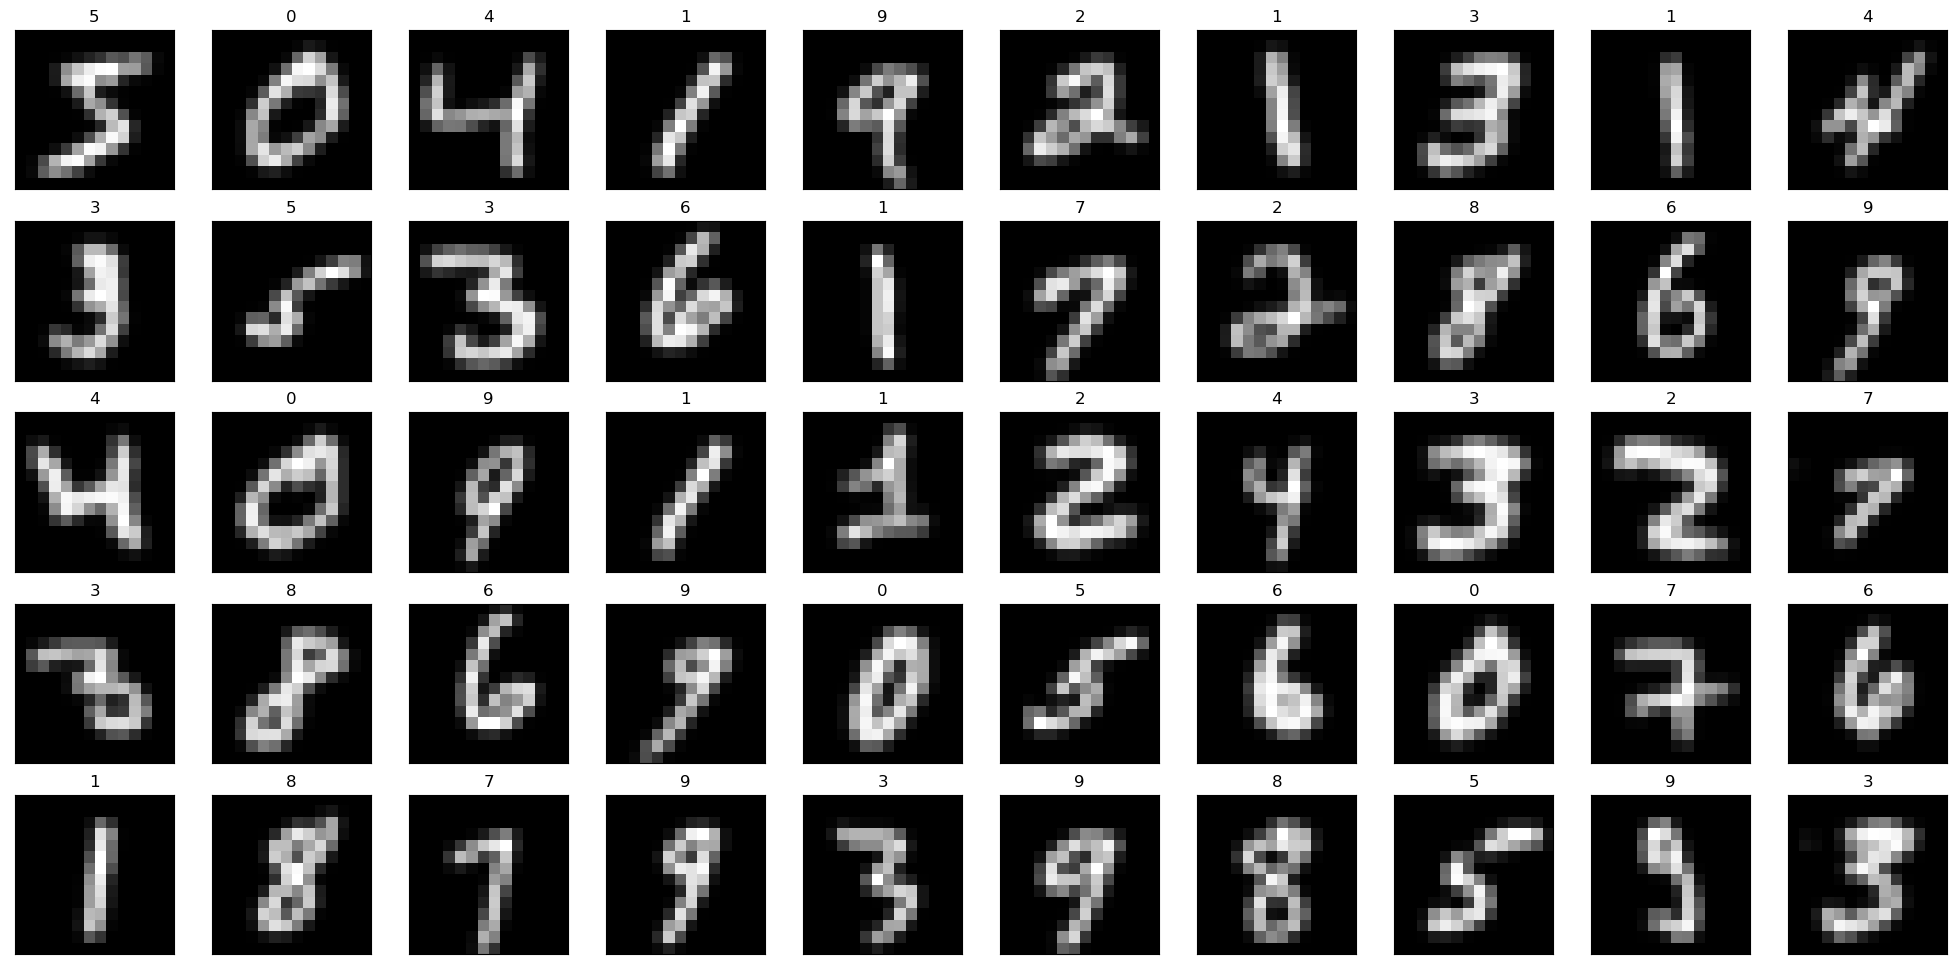

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 12))
for idx in np.arange(min(batch_size, 50)):
    ax = fig.add_subplot(5, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

# Model

In [26]:
import torch.nn as nn
import torch.nn.functional as F

## Define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(resized_img_size*resized_img_size, 64) # nn.Linear(28 * 28, 1000)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)


    def forward(self, x):
        # flatten image input
        x = x.view(-1, resized_img_size * resized_img_size)
        x = F.relu(self.fc1(x))
        # x=F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.fc2(x))
        x = self.fc3(x) # torch.sigmoid(self.fc3(x))
        # x=F.dropout(x, p=0.5, training=self.training)
        return x
        # return x

# Traing Model

In [27]:
from optimizers.ADAM import ADAM
from optimizers.opts import AdaDelta, Momentum, AdaGrad

In [28]:
trainingLoss = {}
# Fixed seed for random weight initialization (to keep the weights same for all
# the models)
# seed = 11 



def trainDifOptimizer(optmzr):
    # torch.manual_seed(seed)
    model = Net()
    criterion = nn.CrossEntropyLoss()
    optimizer = None
    if optmzr=='Adam_scratch':
      optimizer = ADAM(model.parameters(), lr=0.01)
    elif optmzr=='AdaDelta_scratch':
        optimizer = AdaDelta(model.parameters(), lr=0.01) 
    elif optmzr=='AdaGrad_scratch':
        optimizer = AdaGrad(model.parameters(), lr=0.01)
    elif optmzr=='Momentum_scratch':
        optimizer = Momentum(model.parameters(), lr=0.01)
    else:
      optimizer = getattr(torch.optim, optmzr)(model.parameters(), lr=0.01)
    
    n_epochs = 15  # suggest training between 20-50 epochs

    model.train()  # prep model for training
    trainLossForOptimizer = []
    print("Optimizer : ", optmzr, "\n")
    for epoch in range(n_epochs):
        train_loss = 0.0

        for data, target in train_loader:
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item()*data.size(0)

        # print training statistics
        # calculate average loss over an epoch
        train_loss = train_loss/len(train_loader.dataset)
        trainLossForOptimizer.append(train_loss)
        
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(
            epoch+1,
            train_loss
        ))
    torch.save(model, 'saved_models/'+optmzr+'_model')
    trainingLoss[optmzr] = trainLossForOptimizer
    print("\n-----------------------------------------\n")

# optimizersLst = ['Adam_scratch','Adam', 'RMSprop','SGD','Adadelta']
optimizersLst = ['Adam', 'RMSprop','SGD', 'Adadelta','AdaDelta_scratch','AdaGrad_scratch','Adam_scratch']

for optmzr in optimizersLst:
    trainDifOptimizer(optmzr)

print(trainingLoss)

Optimizer :  Adam 

Epoch: 1 	Training Loss: 0.427756
Epoch: 2 	Training Loss: 0.244975
Epoch: 3 	Training Loss: 0.219681
Epoch: 4 	Training Loss: 0.206444
Epoch: 5 	Training Loss: 0.192464
Epoch: 6 	Training Loss: 0.184482
Epoch: 7 	Training Loss: 0.179089
Epoch: 8 	Training Loss: 0.169477
Epoch: 9 	Training Loss: 0.172563
Epoch: 10 	Training Loss: 0.164228
Epoch: 11 	Training Loss: 0.165301
Epoch: 12 	Training Loss: 0.159392
Epoch: 13 	Training Loss: 0.159414
Epoch: 14 	Training Loss: 0.156995
Epoch: 15 	Training Loss: 0.156636

-----------------------------------------

Optimizer :  RMSprop 

Epoch: 1 	Training Loss: 0.642469
Epoch: 2 	Training Loss: 0.298803
Epoch: 3 	Training Loss: 0.251620
Epoch: 4 	Training Loss: 0.229602
Epoch: 5 	Training Loss: 0.214535
Epoch: 6 	Training Loss: 0.201653
Epoch: 7 	Training Loss: 0.198373
Epoch: 8 	Training Loss: 0.190554
Epoch: 9 	Training Loss: 0.184937
Epoch: 10 	Training Loss: 0.180424
Epoch: 11 	Training Loss: 0.177860
Epoch: 12 	Training L

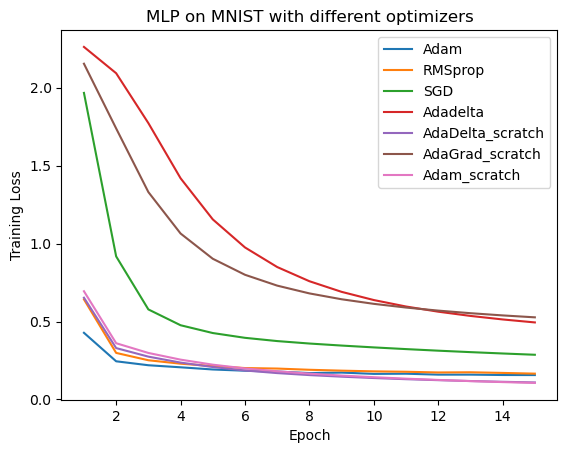

In [29]:
Xval = np.arange(1, 16)

plt.xlabel("Epoch")  # add X-axis label
plt.ylabel("Training Loss")  # add Y-axis label
plt.title("MLP on MNIST with different optimizers")  # add title

for key, value in trainingLoss.items():
    plt.plot(Xval, value, label=key)

plt.legend()
# plt.show()
plt.savefig('MLP_MNIST.png')